本题要求在已知指数未来收益率的情况下，限制交易频率，最⼤化策略收益。

赛题背景

沪深300指数作为中国证券市场的重要指标，其变化直接影响着投资者的决策和市场情绪。该指数由沪
深两市市值⼤、流动性好的300只A股股票组成，⾃2005年4⽉发布以来，已成为衡量市场表现的关键
⼯具。沪深300指数的预测对于投资者理解市场趋势、制定投资策略具有重要意义。本赛题旨在通过数
学建模和数据分析 ，提⾼对沪深300指数未来⾛势的预测准确性，并在此基础上构建有效的交易策略。

本大题共分2个小题目，请依次作答。

赛题说明：

- 交易规则设置：交易开始时仓位为0，每天的仓位上限是100单位，下限是0。每天最多买⼊或卖出
单位是10；
- 优化⽬标：在满⾜交易限制的前提下，实现整个回测周期内最⼤化的收益；
- 在策略设计中明确考虑交易限制，并解其对策略性能的影响；
- 交易执⾏的时间点为每个交易⽇的收盘时间点，交易价格为收盘价；
- 回测时间窗： 2020年1⽉2⽇⾄2023年12⽉29⽇。
提交结果要求：
- 参赛者需提供策略在历史数据上的回测结果 ，包括累计收益、最⼤回撤、夏普⽐率等评估指标（指
标计算⽅法见附录）；
- 提交策略的代码实现，以便评审能够复现优化结果。

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import backtesting as bt
import pyfolio as pf
import datetime

In [72]:
# 设置样式
# 希望上涨用红色，下跌用绿色
# mpf_style = mpf.make_mpf_style(base_mpf_style='tradingview', rc={'font.family': 'SimHei'})
# mpf_style = mpf.make_mpf_style(base_mpf_style='tradingview', rc={'font.family': 'SimHei'}, marketcolors=mpf.make_marketcolors(up='red', down='green'))
# Volume的颜色不能没有
mpf_style = mpf.make_mpf_style(base_mpf_style='tradingview', rc={'font.family': 'SimHei'}, marketcolors=mpf.make_marketcolors(up='red', down='green', volume='in'))

In [73]:
# # plot 显示中文
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

In [74]:
# B题数据\hs300.csv
hs300 = pd.read_csv('hs300.csv')
hs300

,交易日期,开盘点位,最高点位,最低点位,收盘价,成交量(万股),成交额(万),涨跌幅(%)
0,2007-01-04,2073.25,2139.49,2054.24,2067.09,1067197.07,8238107.26,1.28
1,2007-01-05,2051.15,2083.40,2030.76,2072.88,927434.47,6802606.02,0.28
2,2007-01-08,2072.01,2131.74,2071.72,2131.56,847679.09,6630393.61,2.83
3,2007-01-09,2137.49,2201.36,2128.06,2200.09,815776.29,6545619.27,3.22
4,2007-01-10,2210.76,2255.97,2194.77,2255.97,849049.79,6882262.48,2.54
...,...,...,...,...,...,...,...,...
4128,2023-12-25,3330.33,3348.88,3330.33,3347.45,745426.93,12183832.71,0.31
4129,2023-12-26,3345.40,3345.42,3315.94,3324.79,747329.35,12168999.74,-0.68
4130,2023-12-27,3326.93,3341.27,3309.67,3336.36,944039.28,14092492.37,0.35
4131,2023-12-28,3335.56,3423.40,3331.21,3414.54,1480648.51,24585563.45,2.34


In [75]:
hs300['交易日期'] = pd.to_datetime(hs300['交易日期'])
hs300.set_index('交易日期', inplace=True)
hs300

,开盘点位,最高点位,最低点位,收盘价,成交量(万股),成交额(万),涨跌幅(%)
交易日期,,,,,,,
2007-01-04,2073.25,2139.49,2054.24,2067.09,1067197.07,8238107.26,1.28
2007-01-05,2051.15,2083.40,2030.76,2072.88,927434.47,6802606.02,0.28
2007-01-08,2072.01,2131.74,2071.72,2131.56,847679.09,6630393.61,2.83
2007-01-09,2137.49,2201.36,2128.06,2200.09,815776.29,6545619.27,3.22
2007-01-10,2210.76,2255.97,2194.77,2255.97,849049.79,6882262.48,2.54
...,...,...,...,...,...,...,...
2023-12-25,3330.33,3348.88,3330.33,3347.45,745426.93,12183832.71,0.31
2023-12-26,3345.40,3345.42,3315.94,3324.79,747329.35,12168999.74,-0.68
2023-12-27,3326.93,3341.27,3309.67,3336.36,944039.28,14092492.37,0.35


In [76]:
hs300.columns = ['open', 'high', 'low', 'close', 'volume', 'amount', 'pct_chg']

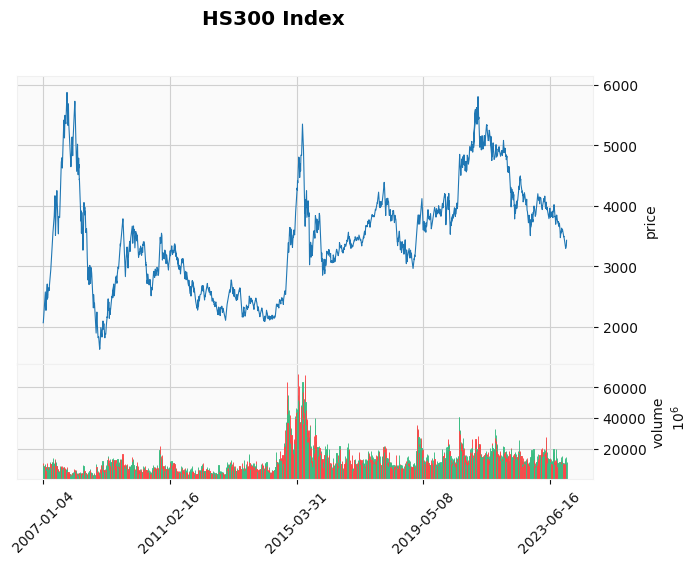

<Figure size 640x480 with 0 Axes>

In [77]:
# 使用 mplfinance 绘制 K 线图
hs300_price = hs300[['open', 'high', 'low', 'close']]
hs300_price = hs300_price.astype(float)
hs300_volume = hs300[['volume', 'amount']]
hs300_volume = hs300_volume.astype(float)
hs300_volume['volume'] = hs300_volume['volume'] * 10000
hs300_volume['amount'] = hs300_volume['amount'] * 10000

hs300_price_and_volume = pd.concat([hs300_price, hs300_volume], axis=1)

mpf.plot(hs300_price_and_volume, type='line', volume=True, title='HS300 Index',
         ylabel='price', ylabel_lower='volume', style='yahoo', datetime_format='%Y-%m-%d',
         show_nontrading=False)
plt.savefig('hs300.png', bbox_inches='tight')
plt.show()

In [78]:
# 回测时间窗 2020年1⽉2⽇⾄2023年12⽉29⽇
hs300_test = hs300.loc['2020-01-02':'2023-12-29']
hs300_learn = hs300.loc['2007-01-04':'2019-12-31']

In [82]:
# hs300_constituent_stocks.csv
cons = pd.read_csv('hs300_constituent_stocks.csv')
cons

,交易日期,股票代码,开盘价,最高价,最低价,收盘价,成交量（手）,成交金额（千元）,总市值,流通股,涨跌幅（%）,权重
0,2007-01-04,1,14.65,15.32,13.83,14.11,69207082.0,1.016723e+09,2.745555e+10,1.409362e+09,-0.024900,1.270
1,2007-01-04,2,15.70,16.56,15.28,15.48,75119519.0,1.206786e+09,6.764603e+10,3.254255e+09,0.002600,3.320
2,2007-01-04,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160
3,2007-01-04,12,11.15,11.30,10.66,10.95,6934903.0,7.560341e+07,1.111932e+10,2.176753e+08,-0.004500,0.140
4,2007-01-04,21,8.38,8.75,8.33,8.38,9271213.0,7.938714e+07,7.370365e+09,3.116781e+08,0.006000,0.170
...,...,...,...,...,...,...,...,...,...,...,...,...
1239889,2023-12-29,688363,67.54,67.98,66.89,66.93,2537752.0,1.707659e+08,3.223872e+10,1.981782e+08,-0.015591,0.080
1239890,2023-12-29,688396,44.57,44.94,44.18,44.69,2923514.0,1.303507e+08,5.899491e+10,1.320092e+09,0.001344,0.144
1239891,2023-12-29,688561,40.19,40.43,39.65,40.09,3084376.0,1.233603e+08,2.746856e+10,4.636838e+08,0.002501,0.072
1239892,2023-12-29,688599,28.90,28.99,28.23,28.53,21452337.0,6.129329e+08,6.201171e+10,2.173562e+09,-0.019588,0.170


In [83]:
cons.columns = ['date', 'code', 'open', 'high', 'low', 'close', 'volume', 'amount', 'market_cap', 'circulation', 'pct_chg', 'weight']
cons['date'] = pd.to_datetime(cons['date'])
cons = cons.astype({
    'open': 'float',
    'high': 'float',
    'low': 'float',
    'close': 'float',
    'volume': 'float',
    'amount': 'float',
    'market_cap': 'float',
    'circulation': 'float',
    'pct_chg': 'float',
    'weight': 'float'
})
cons

,date,code,open,high,low,close,volume,amount,market_cap,circulation,pct_chg,weight
0,2007-01-04,1,14.65,15.32,13.83,14.11,69207082.0,1.016723e+09,2.745555e+10,1.409362e+09,-0.024900,1.270
1,2007-01-04,2,15.70,16.56,15.28,15.48,75119519.0,1.206786e+09,6.764603e+10,3.254255e+09,0.002600,3.320
2,2007-01-04,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160
3,2007-01-04,12,11.15,11.30,10.66,10.95,6934903.0,7.560341e+07,1.111932e+10,2.176753e+08,-0.004500,0.140
4,2007-01-04,21,8.38,8.75,8.33,8.38,9271213.0,7.938714e+07,7.370365e+09,3.116781e+08,0.006000,0.170
...,...,...,...,...,...,...,...,...,...,...,...,...
1239889,2023-12-29,688363,67.54,67.98,66.89,66.93,2537752.0,1.707659e+08,3.223872e+10,1.981782e+08,-0.015591,0.080
1239890,2023-12-29,688396,44.57,44.94,44.18,44.69,2923514.0,1.303507e+08,5.899491e+10,1.320092e+09,0.001344,0.144
1239891,2023-12-29,688561,40.19,40.43,39.65,40.09,3084376.0,1.233603e+08,2.746856e+10,4.636838e+08,0.002501,0.072
1239892,2023-12-29,688599,28.90,28.99,28.23,28.53,21452337.0,6.129329e+08,6.201171e+10,2.173562e+09,-0.019588,0.170


In [84]:
cons_test = cons.loc[cons['date'] >= '2020-01-02']
cons_learn = cons.loc[cons['date'] < '2020-01-02']